# 异常检测和推荐系统

此Notebook是配合Andrew Ng "Machine Leanring"中[异常检测](https://github.com/loveunk/machine-learning-deep-learning-notes/blob/master/machine-learning/anomaly-detection.md)和[推荐系统](https://github.com/loveunk/machine-learning-deep-learning-notes/blob/master/machine-learning/recommender-system.md)部分学习使用。

测试用python版本为3.6
* 机器学习路径：https://github.com/loveunk/machine-learning-deep-learning-notes/
* 内容正文综合参考网络资源，使用中如果有疑问请联络：https://www.kaikai.ai

在本练习的第一部分，你将使用高斯模型实现异常检测算法，并将其应用于检测网络上的故障服务器。
在第二部分，你将使用协作过滤构建一个推荐系统，并将其应用于电影推荐数据集。

## 1. 异常检测（Anomaly detection）

在这个练习中，你将实现一个异常检测算法，该算法用来检测服务器的异常状态。
数据集的特征包括每个服务器的吞吐量（Throughput）、延迟（Latency）。
当服务器在工作的时候，你收集了 $m=307$个样本，每个样本记录了服务器的状态，因此你有一个未标记的数据集 $\{x^{(1)}, ..., x^{(m)}\}$。
你猜测数据集中大部分样本是“正常（normal）”的，但是有少量的样本是“异常（Anomal）”的。

你将使用高斯模型来检测数据集。
先从一个简单的二维数据集开始，可视化将帮助你感受该算法是如何工作的。
在这个数据集上，你将拟合一个高斯分布，然后找到那些很低概率的值，这些值可以被认为是异常的。
之后，你将把异常检测算法应用到一个有着更多维度的更大的数据集。

下面先加载数据集，看一看。

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
from scipy import stats

In [2]:
data = loadmat('data/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

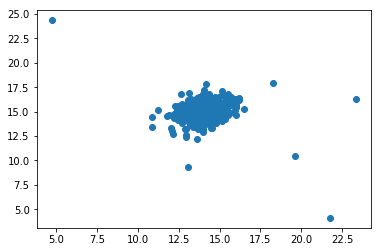

In [16]:
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])
plt.show()

从图中，可以看出，这是一个非常紧密的聚类，几个值远离了聚类。
在这个简单的例子中，这些可以被认为是异常的。 

### 1.1 高斯分布

想要做异常检测，你首先需要拟合一个针对该数据的模型。

对于给定的数据集$\{x^{(1)}, ..., x^{(m)}\}$（其中$x^{(1)} \in \mathbb{R}^n$），你想为数据中的每个特征$i = 1, ..., n$估计高斯分布。
为此，我们将创建一个返回每个要素的均值($\mu_i$)和方差的函数$\sigma^2_i$。

高斯分布的公式为：
$$
p(x; \mu, \sigma^2) = \dfrac{1}{\sqrt{2\pi\sigma^2}} e^{-\dfrac{(x-\mu)^2}{2\sigma^2}}
$$

其中为$\mu$为均值，$\sigma^2$为方差。

### 1.2 估算高斯分布的参数

均值($\mu_i$)公式为：
$$\mu_i = \dfrac{1}{m}\sum_{j=1}^m x_i^{(j)}$$

方差$\sigma^2_i$公式为：
$$\sigma^2_i = \dfrac{1}{m}\sum_{j=1}^m(x_i^{(j)} - \mu_i)^2$$

In [4]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)

    return mu, sigma

In [5]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

接下来绘制拟合的效果。

因为之后将使用多变量高斯模型，因此将计算协方差矩阵，不再使用sigma。

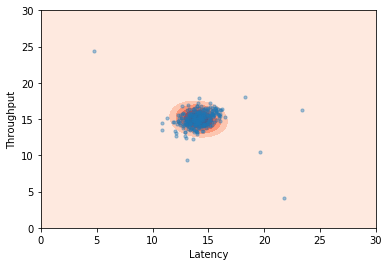

In [28]:
# 创建多变量高斯模型
mu = X.mean(axis=0)
cov = np.cov(X.T)
multi_normal = stats.multivariate_normal(mu, cov)

# 创建 grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots()

# 绘制概率密度
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Reds')

# 绘制原始数据点
sb.regplot('Latency', 'Throughput',
           data=pd.DataFrame(X, columns=['Latency', 'Throughput']), 
           fit_reg=False,
           ax=ax,
           scatter_kws={"s":10,
                        "alpha":0.4})
plt.show()

### 1.3 选择阈值$\epsilon$

现在我们有了高斯分布的参数。对于给定的分布，你可以评估哪些样本有较高的概率，哪些有较低的概率。
低概率的样本意味着更可能是数据集中的异常。

决定一个哪些样本是异常的一个办法是基于交叉验证集选择一个阈值。
当一个样本的概率小于阈值的时候，这个样本应该被认为是一个异常。

在这部分练习中，你将实现一个基于交叉验证集$F_1\text{ Score}$选择阈值$\epsilon$的算法。

为此，我们需要使用一组标记的验证数据（其中真实异常样本已被标记），并在给出不同阈值的情况下，对模型的性能进行鉴定。

首先，加载数据集：

In [20]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

我们还需要为验证集（使用相同的模型参数）执行此操作。 

我们将使用与真实标签组合的这些概率来确定将数据点分配为异常的最佳概率阈值。

In [29]:
mu = X.mean(axis=0)
cov = np.cov(X.T)

multi_normal = stats.multivariate_normal(mu, cov)

pval = multi_normal.pdf(Xval)

接下来，我们需要一个函数，找到给定概率密度值和真实标签的最佳阈值。 为了做到这一点，我们将为不同的epsilon值计算F1分数。 F1是真阳性，假阳性和假阴性的数量的函数。

方程式如下：
$$F_1 = \dfrac{2 \cdot prec \cdot rec}{prec + rec}$$

查准率 Precision：
$$prec = \dfrac{tp}{tp + fp}$$

查全率 Recall：
$$rec = \dfrac{tp}{tp + fn}$$

其中：
* $tp$ 是真正例（true positive）
* $fp$ 是假正例（false positive）
* $fn$ 是假反例（false nagative）

In [62]:
"""
计算F1 Score的函数。
也可以使用sklearn.metrics.f1_score计算F1 Score，下面是一种实现。
"""
def f1_score(yval, preds):
    tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
    fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
    fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)

    # f1 = (2 * precision * recall) / (precision + recall) 
    # F1 Score也可以化简为如下公式，避免当tp == 0 && fp == 0时计算出现NaN的情况
    f1 = 2*tp / (2*tp + fn + fp)
    return f1


import sklearn.metrics
"""
选择最佳epsilon值，使得F1 Score最大值
"""
def select_threshold(pval, yval):
    epsilons = np.linspace(np.min(pval), np.max(pval), num=1000)
    fs = []

    for epsilon in epsilons:
        preds = (pval < epsilon).astype('int')

        fs.append(sk.metrics.f1_score(yval, preds))

    # print(fs)
    argmax_fs = np.argmax(fs)

    return epsilons[argmax_fs], fs[argmax_fs]

In [63]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

D:\Anaconda3\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(9.045285962118505e-05, 0.8750000000000001)

最后，我们可以将阈值应用于数据集，并可视化结果。

In [64]:
# 得到异常值的索引
p = multi_normal.pdf(X)
outliers = np.where(p < epsilon)

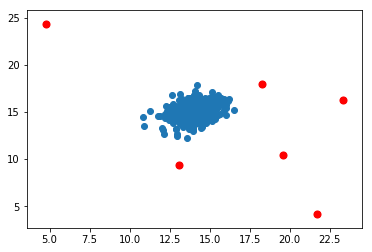

In [65]:
# 画出异常点
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()

红点是被标记为异常值的点。 这些看起来很合理。 有一些分离（但没有被标记）的右上角也可能是一个异常值，但是相当接近。

### 1.4 高维数据集

In [68]:
data = loadmat('data/ex8data2.mat')

X = data['X']
Xval = data['Xval']
yval = data['yval']

mu, cov = X.mean(axis=0), np.cov(X.T)
multi_normal = stats.multivariate_normal(mu, cov)

In [69]:
pval = multi_normal.pdf(Xval)

epsilon, f1 = select_threshold(pval, yval)
epsilon, f1
print(epsilon, f1)

p = multi_normal.pdf(X)
print('find {} anamolies'.format(np.sum((p <= epsilon).astype('int'))))

# 结果是122个异常，接近原Assignment里的117，但有一点差异，目前猜测和Python里的计算精度有关？待验证

D:\Anaconda3\envs\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1.748247887556513e-18 0.5517241379310345
find 122 anamolies


## 2. 推荐系统

推荐引擎使用基于项目和用户的相似性度量来检查用户的历史偏好，以便为用户可能感兴趣的新“事物”提供建议。

在本练习中，我们将实现一种称为协作过滤的特定推荐系统算法，并将其应用于电影评分的数据集。

### 2.1 电影评分数据集
我们首先加载并检查我们将要使用的电影评分数据集。

In [ ]:
data = loadmat('data/ex8_movies.mat')

Y是包含从1到5的等级的（数量的电影x数量的用户）数组。

R是包含指示用户是否给电影评分的二进制值的“指示符”数组。 两者应该具有相同的维度。

In [ ]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

我们可以通过平均排序Y来评估电影的平均评级。

In [ ]:
Y[1,np.where(R[1,:]==1)[0]].mean()

我们还可以通过将矩阵渲染成图像来尝试“可视化”数据。 我们不能从这里收集太多，但它确实给我们了解用户和电影的相对密度。

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()
plt.show()

接下来，我们将实施协同过滤的代价函数。 直觉上，“代价”是指一组电影评级预测偏离真实预测的程度。 代价方程在练习文本中给出。 它基于文本中称为X和Theta的两组参数矩阵。 这些“展开”到“参数”输入中，以便稍后可以使用SciPy的优化包。 请注意，我已经在注释中包含数组/矩阵形状（对于我们在本练习中使用的数据），以帮助说明矩阵交互如何工作。
# cost
<img style="float: left;" src="../img/rcmd_cost.png">

In [ ]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

为了测试这一点，我们提供了一组我们可以评估的预训练参数。 为了保持评估时间的少点，我们将只看一小段数据。

In [ ]:
params_data = loadmat('data/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

In [ ]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

cost(params, Y_sub, R_sub, features)

 接下来我们需要实现梯度计算。 就像我们在练习4中使用神经网络实现一样，我们将扩展代价函数来计算梯度。

In [ ]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta
    Theta_grad = error.T * X
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [ ]:
J, grad = cost(params, Y_sub, R_sub, features)
J, grad

我们的下一步是在代价和梯度计算中添加正则化。 我们将创建一个最终的正则化版本的功能（请注意，此版本包含一个额外的“学习率”参数，在文本中称为“lambda”）。

In [ ]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [ ]:
J, grad = cost(params, Y_sub, R_sub, features, 1.5)
J, grad

这个结果再次与练习代码的预期输出相匹配，所以看起来正则化是正常的。 在我们训练模型之前，我们有一个最后步骤， 我们的任务是创建自己的电影评分，以便我们可以使用该模型来生成个性化的推荐。 为我们提供一个连接电影索引到其标题的文件。 接着我们将文件加载到字典中。

In [ ]:
movie_idx = {}
f = open('data/movie_ids.txt',encoding= 'gbk')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [ ]:
movie_idx[0]

我们将使用练习中提供的评分。

In [ ]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

We can add our own ratings vector to the existing data set to include in the model.
我们可以将自己的评级向量添加到现有数据集中以包含在模型中。

In [ ]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape, ratings.shape

我们不只是准备训练协同过滤模型。 我们只需要定义一些变量并对评级进行规一化。

In [ ]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

In [ ]:
Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

Ynorm.mean()

In [ ]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

In [ ]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

我们训练好的参数是X和Theta。 我们可以使用这些来为我们添加的用户创建一些建议。

In [ ]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean
my_preds.shape

In [ ]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

这给了我们一个排名最高的评级，但我们失去了这些评级的索引。 我们实际上需要使用argsort函数来预测评分对应的电影。

In [ ]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

In [ ]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

> 推荐的电影实际上并不符合练习文本中的内容， 还没有找到原因在哪里。